In [1]:
import cv2,os
import time
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from skimage import io, transform
from skimage.io import imread, imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cpu)


# data-science-bowl-2018

In [66]:
batch_size=1
image_size=512

data_dir = "../../Datasets/data-science-bowl-2018/stage1_train/"

In [67]:
get_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
])

In [68]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)

    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
    
        img = io.imread(image_path)[:,:,:3]
        img = transform.resize(img, (image_size,image_size))
        mask = self.get_mask(mask_folder, image_size)

        image = get_transform(img).to(torch.float32)
        mask = get_transform(mask).to(torch.float32)
        
        return (image,mask) 

    def get_mask(self, mask_folder, img_size):
        mask = np.zeros((img_size, img_size, 1),dtype=bool)
        boxes = []
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (img_size, img_size))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
        return mask
        
    def __len__(self):
        return len(self.folders)

len(datas):  670
image:  torch.Size([3, 512, 512])
mask:  torch.Size([1, 512, 512])


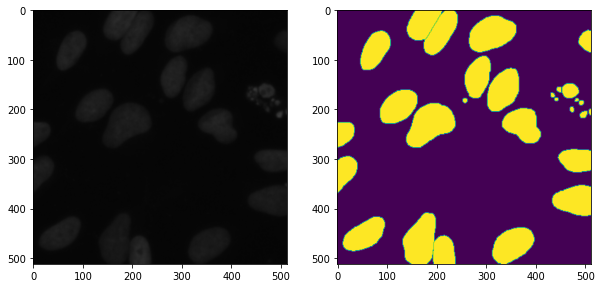

In [69]:
datas = CustomDataset(data_dir)
print("len(datas): ",len(datas))

image, mask = datas[0]
print("image: ",image.shape)
# print(torch.amax(image).item(),torch.amin(image).item())
print("mask: ",mask.shape)
# print(torch.amax(mask).item(),torch.amin(mask).item())

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0))

In [70]:
train_len = int(0.8*len(datas))
val_len = len(datas)-train_len
train_data, val_data = torch.utils.data.random_split(datas, [train_len, val_len])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

print(f"train_data: {len(train_data)}, val_data: {len(val_data)}")
print(f"train_loader: {len(train_loader)}, val_loader: {len(val_loader)}")

train_data: 536, val_data: 134
train_loader: 536, val_loader: 134


torch.float32
torch.float32
val_imgs: torch.Size([1, 3, 512, 512]), val_masks: torch.Size([1, 1, 512, 512])


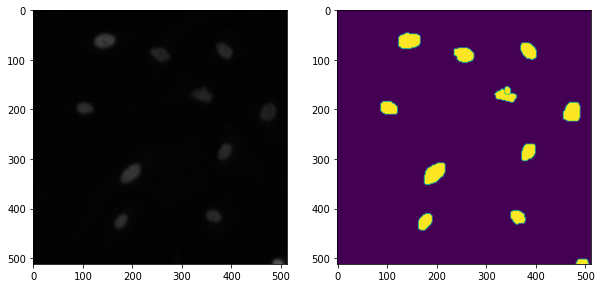

In [37]:
val_imgs, val_masks = iter(val_loader).next()
print(datas[0][0].dtype)
print(val_imgs.dtype)
print(f"val_imgs: {val_imgs.shape}, val_masks: {val_masks.shape}")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(val_imgs[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(val_masks[0].permute(1,2,0))

# build model 

In [3]:
def calculate_iou(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou


def calculate_iou_batch(y_pred,y):
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(calculate_iou(pred, label))
    iou = np.nanmean(ious)
    return iou   

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)
    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [7]:
model = UNet().to(device)
model_weight_unet2018bowl = torch.load('./qsub_pytorch/qsub220614/pytorch_unet_2018bowl_30.pt')
model.load_state_dict(model_weight_unet2018bowl)

image = torch.rand((1,3,image_size,image_size)).to(device)
model(image).shape

# build loss

In [42]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final 

# train model

In [43]:
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(),lr= learning_rate)
criterion = DiceBCELoss()
epochs = 10

In [44]:
def train(model, train_loader):
    model.train()
    train_loss, train_score, target_count = 0, 0, 0
    
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        train_loss += loss.item()
        train_score += score
        target_count += masks.shape[0]
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/target_count, train_score / target_count

In [45]:
def validate(model,val_loader):
    model.eval()
    val_loss, val_score, target_count = 0, 0, 0
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        val_loss += loss.item()
        val_score += score
        target_count += masks.shape[0]

    return val_loss/target_count, val_score / target_count

In [13]:
train_loss_history,val_loss_history = [],[]
train_iou_history,val_iou_history = [],[]

for epoch in range(epochs):
    train_loss, train_score = train(model, train_loader)
    val_loss, val_score = validate(model, val_loader)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_iou_history.append(train_score)
    val_iou_history.append(val_score)
    print(f"Epoch {epoch}: train_score/val_score {train_score}/{val_score} train_loss/val_loss {train_loss}/{val_loss}")

In [ ]:
torch.save(model.state_dict(), 'pytorch_unet_2018bowl.pt')

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Loss','Val Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_iou_history,'-o')
plt.plot(val_iou_history,'-o')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Score','Val Score'])
plt.title('Train Score and Val Score')
plt.show()

# test model

In [227]:
model = UNet().to(device)
model_weight_unet2018bowl = torch.load('./qsub_pytorch/qsub220614/pytorch_unet_2018bowl_20.pt')
model.load_state_dict(model_weight_unet2018bowl)

<All keys matched successfully>

In [234]:
imgs,masks = next(iter(val_loader))
print(imgs.shape,masks.shape)

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


images: torch.Size([1, 3, 512, 512])
masks: torch.Size([1, 1, 512, 512])
predict_masks: torch.Size([1, 1, 512, 512])


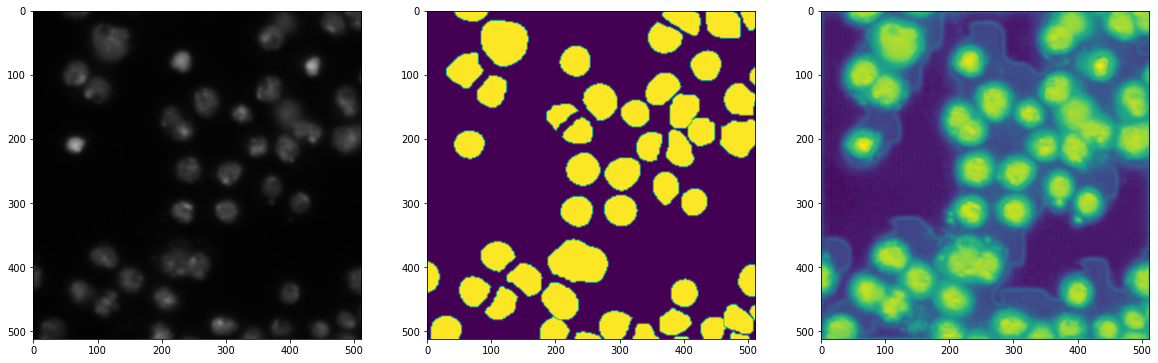

In [235]:
n = 0
images = imgs[n:n+1].to(device)
predict_masks = model(images)
print(f"images: {images.shape}")
print(f"masks: {masks.shape}")
print(f"predict_masks: {predict_masks.shape}")

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(images[0].permute(1, 2, 0).cpu())
plt.subplot(1,3,2)
plt.imshow(masks[n].permute(1, 2, 0).cpu())
plt.subplot(1,3,3)
plt.imshow(predict_masks[0].permute(1, 2, 0).detach().cpu().numpy())

## get mask

In [177]:
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes

from torchvision.ops import masks_to_boxes

torch.Size([1, 512, 512])
tensor(11.5788) tensor(-23.3508)


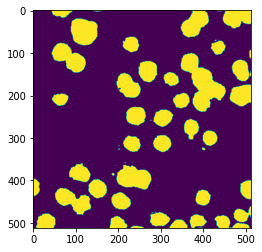

In [240]:
predict_mask = predict_masks[0].detach().cpu()
print(predict_mask.size())
print(torch.amax(predict_mask),torch.amin(predict_mask))

predict_mask = predict_mask.ge(0)
plt.imshow(predict_mask.permute(1, 2, 0))

torch.Size([1, 4])
tensor([[  0.,   0., 511., 511.]])


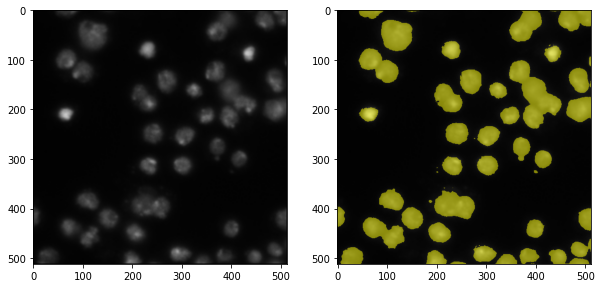

In [250]:
boxes = masks_to_boxes(predict_mask)
print(boxes.size())
print(boxes)

backimg = (images[0]*300).to(torch.uint8).cpu()
with_boxes = draw_bounding_boxes(backimg, boxes)
with_masks = draw_segmentation_masks(backimg, predict_mask, alpha=0.5, colors=["yellow"])

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(with_boxes,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(with_masks,(1,2,0)))

# eval model

In [126]:
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(sharpness_factor=10),
])

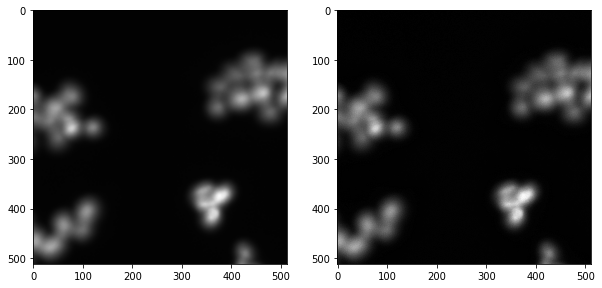

In [265]:
path = "../../Datasets/211202NDAcquisition/NDAcquisition-01x20/NDAcquisition-01_XY208.ome.tif"
i,j = 1,1
img = cv2.imread(path)
img = img[i*512:(i+1)*512,j*512:(j+1)*512,:]

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(eval_transform(img).permute(1,2,0))

output.shape:  torch.Size([1, 512, 512])
tensor(4.6873) tensor(-27.4827)


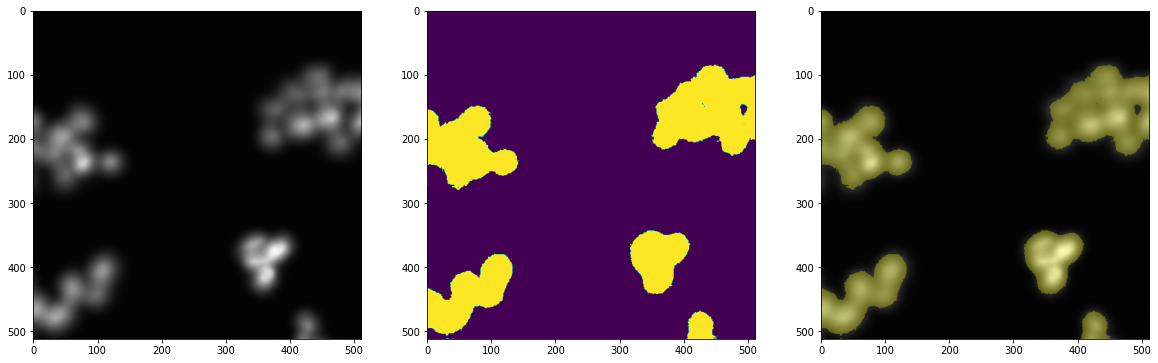

In [272]:
model.eval()
output = model(eval_transform(img).to(device).unsqueeze(0))[0].detach().cpu()
print("output.shape: ",output.shape)
print(torch.amax(output),torch.amin(output))

backimg = torch.tensor(np.transpose(img,(2,0,1)))
masks = output.ge(-10)
with_masks = draw_segmentation_masks(backimg, masks, alpha=0.3, colors=["yellow"])

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(masks.permute(1, 2, 0))
plt.subplot(1,3,3)
plt.imshow(with_masks.permute(1, 2, 0))